# Predict BTC price direction - Random Forest Classifier

In [145]:
# Import libraries
import numpy as np
import pandas as pd
from pathlib import Path
import os
import requests
import datetime

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

%matplotlib inline

In [146]:
# Read in annual coin metrics from csv
metrics_2021 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_1.csv', parse_dates=True)
metrics_2020 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_2.csv', parse_dates=True)
metrics_2019 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_3.csv', parse_dates=True)
metrics_2018 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_4.csv', parse_dates=True)
metrics_2017 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_5.csv', parse_dates=True)
metrics_2016 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_6.csv', parse_dates=True)
metrics_2015 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_7.csv', parse_dates=True)
metrics_2014 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_8.csv', parse_dates=True)
metrics_2013 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_9.csv', parse_dates=True)
metrics_2012 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_10.csv', parse_dates=True)
metrics_2011 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_11.csv', parse_dates=True)
metrics_2010 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_12.csv', parse_dates=True)
metrics_2009 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_13.csv', parse_dates=True)

In [147]:
# Read in combined BTC Google trends data
btc_google_trends = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_google_trends/btc_trends_combined.csv', parse_dates=True)
btc_google_trends.reset_index(inplace=True)
btc_google_trends.rename(columns={'date':'time', 'bitcoin':'BTC_Trends'},inplace=True)
btc_google_trends = btc_google_trends.drop(columns='index')
btc_google_trends['time'] = pd.to_datetime(btc_google_trends['time']).dt.date
btc_google_trends = btc_google_trends.set_index('time')
btc_google_trends.tail()

,BTC_Trends
time,
2021-07-13,18
2021-07-14,18
2021-07-15,18
2021-07-16,18
2021-07-17,17


In [148]:
# Concat all csv files  and print combined csv
combined = pd.concat([metrics_2009,metrics_2010,metrics_2011,metrics_2012,metrics_2013,metrics_2014,metrics_2015,metrics_2016,metrics_2017,metrics_2018,metrics_2019,metrics_2020,metrics_2021], axis=0)
combined_df = pd.DataFrame(combined)
combined_df = combined_df.drop_duplicates(keep='first')
combined_df.tail()

,time,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr
194,2021-07-14 00:00:00+00:00,btc,817900,1.697935,6.151814e+11,1.213783e+08,114.337877,32798.284519,1.875651e+07,235584,5.380382e+09,11.498030
195,2021-07-15 00:00:00+00:00,btc,828844,1.643649,5.947511e+11,9.139070e+07,71.134357,31707.690037,1.875731e+07,224713,8.360954e+09,11.494535
196,2021-07-16 00:00:00+00:00,btc,764392,1.632215,5.900542e+11,1.070985e+08,81.211930,31455.717582,1.875825e+07,223179,7.265610e+09,11.464107
197,2021-07-17 00:00:00+00:00,btc,640355,1.630400,5.918126e+11,1.018260e+08,108.230430,31547.951199,1.875914e+07,181727,5.468079e+09,11.456624
198,2021-07-18 00:00:00+00:00,btc,651828,1.639258,5.948379e+11,9.787224e+07,123.714333,31707.703853,1.876004e+07,163158,4.808157e+09,11.461719


In [149]:
combined_df.isnull().sum()

time                0
asset               0
AdrActCnt           0
CapMVRVCur        561
CapMrktCurUSD     561
HashRate            6
NVTAdj            260
PriceUSD          561
SplyCur             0
TxCnt               0
TxTfrValAdjUSD    561
VelCur1yr           6
dtype: int64

In [150]:
combined_df.dropna(inplace=True)
combined_df.isnull().sum()

time              0
asset             0
AdrActCnt         0
CapMVRVCur        0
CapMrktCurUSD     0
HashRate          0
NVTAdj            0
PriceUSD          0
SplyCur           0
TxCnt             0
TxTfrValAdjUSD    0
VelCur1yr         0
dtype: int64

In [151]:
# Remove timestamp in time column
combined_df['time'] = pd.to_datetime(combined_df['time']).dt.date
combined_df = combined_df.set_index('time')
combined_df.tail()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr
time,,,,,,,,,,,
2021-07-14,btc,817900,1.697935,6.151814e+11,1.213783e+08,114.337877,32798.284519,1.875651e+07,235584,5.380382e+09,11.498030
2021-07-15,btc,828844,1.643649,5.947511e+11,9.139070e+07,71.134357,31707.690037,1.875731e+07,224713,8.360954e+09,11.494535
2021-07-16,btc,764392,1.632215,5.900542e+11,1.070985e+08,81.211930,31455.717582,1.875825e+07,223179,7.265610e+09,11.464107
2021-07-17,btc,640355,1.630400,5.918126e+11,1.018260e+08,108.230430,31547.951199,1.875914e+07,181727,5.468079e+09,11.456624
2021-07-18,btc,651828,1.639258,5.948379e+11,9.787224e+07,123.714333,31707.703853,1.876004e+07,163158,4.808157e+09,11.461719


In [152]:
# Concat metrics and google trends data
combined_df = pd.concat([combined_df,btc_google_trends],axis=1).dropna()
combined_df = combined_df.reset_index()
combined_df = combined_df.rename(columns={'index':'time'})
combined_df = combined_df.set_index('time')
combined_df.tail()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr,BTC_Trends
time,,,,,,,,,,,,
2021-07-13,btc,807050.0,1.688811,6.122149e+11,9.710262e+07,104.143050,32641.975961,1.875545e+07,227411.0,5.878596e+09,11.488971,18.0
2021-07-14,btc,817900.0,1.697935,6.151814e+11,1.213783e+08,114.337877,32798.284519,1.875651e+07,235584.0,5.380382e+09,11.498030,18.0
2021-07-15,btc,828844.0,1.643649,5.947511e+11,9.139070e+07,71.134357,31707.690037,1.875731e+07,224713.0,8.360954e+09,11.494535,18.0
2021-07-16,btc,764392.0,1.632215,5.900542e+11,1.070985e+08,81.211930,31455.717582,1.875825e+07,223179.0,7.265610e+09,11.464107,18.0
2021-07-17,btc,640355.0,1.630400,5.918126e+11,1.018260e+08,108.230430,31547.951199,1.875914e+07,181727.0,5.468079e+09,11.456624,17.0


In [153]:
combined_df.to_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_metrics_combined.csv')

<AxesSubplot:title={'center':'EMA BTC'}, xlabel='time', ylabel='BTC Price ($)'>

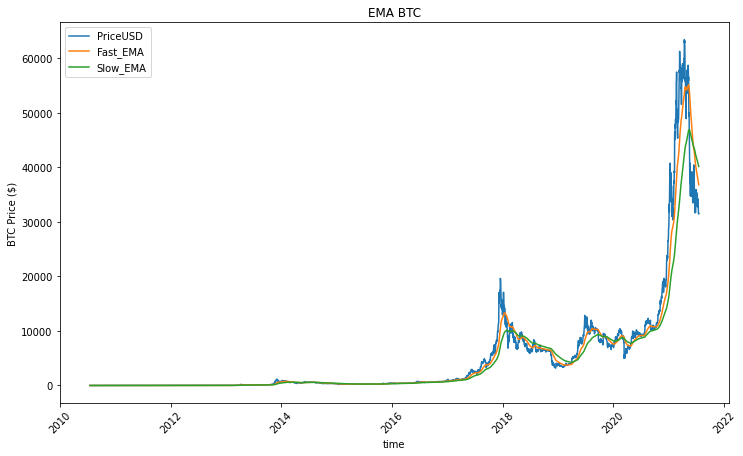

In [155]:
# Set short and long windows for EMA (Exponential Moving Average)
short_window = 20
long_window = 50

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
combined_df['Fast_EMA'] = combined_df['PriceUSD'].ewm(halflife=short_window).mean()
combined_df['Slow_EMA'] = combined_df['PriceUSD'].ewm(halflife=long_window).mean()

# Plot the EMA of ETH closing prices
combined_df[['PriceUSD', 'Fast_EMA', 'Slow_EMA']].plot(figsize=(12,7), title='EMA BTC', ylabel='BTC Price ($)', rot=45) 

In [156]:
# Construct a crossover trading signal
combined_df['Crossover_Long'] = np.where(combined_df['Fast_EMA'] > combined_df['Slow_EMA'], 1.0, 0.0)
combined_df['Crossover_Short'] = np.where(combined_df['Fast_EMA'] < combined_df['Slow_EMA'],-1.0, 0.0)
combined_df['Crossover_Signal'] = combined_df['Crossover_Long'] + combined_df['Crossover_Short']

In [157]:
# Calculate daily return
combined_df['Daily_Return'] = combined_df['PriceUSD'].pct_change()

In [158]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
combined_df['Positive_Return'] = np.where(combined_df['Daily_Return'] > 0, 1.0, 0.0)

combined_df = combined_df.dropna()

# Convert date to str to set test and train windows 
combined_df.index = pd.to_datetime(combined_df.index, format = '%Y/%m/%d')
combined_df.tail()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr,BTC_Trends,Fast_EMA,Slow_EMA,Crossover_Long,Crossover_Short,Crossover_Signal,Daily_Return,Positive_Return
time,,,,,,,,,,,,,,,,,,,
2021-07-13,btc,807050.0,1.688811,6.122149e+11,9.710262e+07,104.143050,32641.975961,1.875545e+07,227411.0,5.878596e+09,11.488971,18.0,37577.198117,40641.363981,0.0,-1.0,-1.0,-0.014886,0.0
2021-07-14,btc,817900.0,1.697935,6.151814e+11,1.213783e+08,114.337877,32798.284519,1.875651e+07,235584.0,5.380382e+09,11.498030,18.0,37414.410776,40533.385989,0.0,-1.0,-1.0,0.004789,1.0
2021-07-15,btc,828844.0,1.643649,5.947511e+11,9.139070e+07,71.134357,31707.690037,1.875731e+07,224713.0,8.360954e+09,11.494535,18.0,37220.018918,40411.880025,0.0,-1.0,-1.0,-0.033252,0.0
2021-07-16,btc,764392.0,1.632215,5.900542e+11,1.070985e+08,81.211930,31455.717582,1.875825e+07,223179.0,7.265610e+09,11.464107,18.0,37023.665653,40288.577890,0.0,-1.0,-1.0,-0.007947,0.0
2021-07-17,btc,640355.0,1.630400,5.918126e+11,1.018260e+08,108.230430,31547.951199,1.875914e+07,181727.0,5.468079e+09,11.456624,17.0,36837.142717,40168.243099,0.0,-1.0,-1.0,0.002932,1.0


In [159]:
# Select model features and timeframe for train data
X = combined_df[['AdrActCnt','CapMrktCurUSD','CapMVRVCur','HashRate','NVTAdj','TxCnt','TxTfrValAdjUSD','VelCur1yr','Crossover_Signal','BTC_Trends']]
X_train = X[:'2020']

In [160]:
# Select prediction variable and timeframe for train data
y = combined_df['Positive_Return']
y_train = y[:'2020']

In [161]:
# Define timeframe for testing data
X_test = X['2021':]
y_test = y['2021':]

In [162]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [163]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

In [164]:
# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [165]:
# Perform the grid search for the optimal set of tree parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

n_estimators = [20,500]
max_depth= [5,10]
num_folds = 10
scoring = 'accuracy'

criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, \
  criterion = criterion )

model = RandomForestClassifier(n_jobs=-1)

kfold = KFold(n_splits=num_folds, random_state=None)
grid = GridSearchCV(estimator=model, param_grid=param_grid, \
  scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_,\
  grid_result.best_params_))

Best: 0.537830 using {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}


In [166]:
# Define the model with the optimized set of parameters
model = RandomForestClassifier(criterion='gini', max_depth=5,n_estimators=20, n_jobs=-1)

In [167]:
# Fit the model
model = model.fit(X_train_scaled, y_train)

In [168]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [169]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [170]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,2,95
Actual 1,2,99


Accuracy Score : 0.51010101010101
Classification Report
              precision    recall  f1-score   support

         0.0       0.50      0.02      0.04        97
         1.0       0.51      0.98      0.67       101

    accuracy                           0.51       198
   macro avg       0.51      0.50      0.36       198
weighted avg       0.51      0.51      0.36       198



In [ ]:
# I will try to increase predictive ability of the model by excluding certain features and with further hyperparameter tuning. 

In [171]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results[-20:]

,Positive_Return,Predicted Value
time,,
2021-06-28,0.0,1.0
2021-06-29,1.0,1.0
2021-06-30,0.0,1.0
2021-07-01,0.0,1.0
2021-07-02,1.0,1.0
2021-07-03,1.0,1.0
2021-07-04,1.0,1.0
2021-07-05,0.0,1.0
2021-07-06,1.0,1.0


In [172]:
# List the features sorted in descending order by feature importance
importances = model.feature_importances_
sorted(zip(model.feature_importances_, X.columns), reverse=True)[:10]

[(0.1584539291230437, 'VelCur1yr'),
 (0.1482288085251891, 'NVTAdj'),
 (0.14641399042206238, 'CapMVRVCur'),
 (0.10952868173597113, 'TxCnt'),
 (0.09934869913064844, 'AdrActCnt'),
 (0.09812743100090189, 'CapMrktCurUSD'),
 (0.09403204782214974, 'BTC_Trends'),
 (0.07212700113142806, 'HashRate'),
 (0.07151416901353104, 'TxTfrValAdjUSD'),
 (0.0022252420950746674, 'Crossover_Signal')]

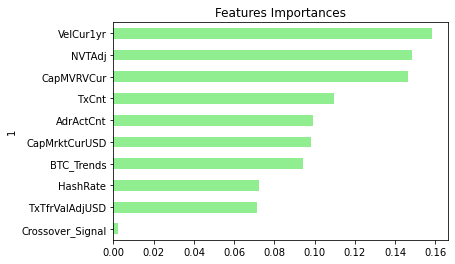

In [173]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(model.feature_importances_,    X.columns), reverse=True))[:10]
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)

importances_sorted = importances_df.sort_values(by=
'Feature Importances')

importances_plot = importances_sorted.plot(kind='barh', color='lightgreen', title='Features Importances', legend=False)

## Modified RF Classifier
### Hyperparameter tuning and feature combinations to improve predictive ability of the classification model

In [181]:
# Select model features and timeframe for train data
X = combined_df[['CapMVRVCur']]
X_train = X.loc[:'2020']
y = combined_df['Positive_Return']
y_train = y[:'2020']
X_test = X['2021':]
y_test = y['2021':]
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [182]:
# Define the model using optimized settings
model = RandomForestClassifier(criterion='gini', max_depth=5,n_estimators=20, n_jobs=-1)

In [183]:
# Fit the model
model = model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,13,84
Actual 1,18,83


Accuracy Score : 0.48484848484848486
Classification Report
              precision    recall  f1-score   support

         0.0       0.42      0.13      0.20        97
         1.0       0.50      0.82      0.62       101

    accuracy                           0.48       198
   macro avg       0.46      0.48      0.41       198
weighted avg       0.46      0.48      0.42       198



In [ ]:
# Reduction of features to most important two improved the predictive ability of the model for both positive and negative return. However, high recall score of positive prediction would allow false positives and potential financial loss. 